# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [18]:
# Load pickled data
import pickle

training_file = 'dataset/train.p'
validation_file = 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.   
**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
import csv

# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape

# Number of unique classes/labels there are in the dataset.
with open('signnames.csv',"r") as f:
    reader = csv.reader(f, delimiter = ",")
    data = list(reader)
    n_classes = len(data) - 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

11


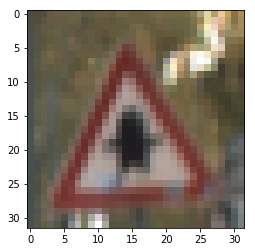

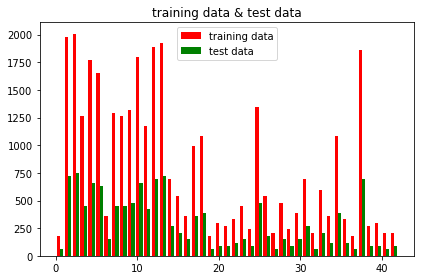

In [3]:
import random
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[8955].squeeze()

plt.imshow(image)
print(y_train[8955])

np.random.seed(0)

n_bins = 43
x = y_train, y_test
fig, ax = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'green']
labels = ['training data', 'test data']
ax.hist(x, bins=n_bins, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('training data & test data')

fig.tight_layout()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

With the LeNet-5 solution from the lecture, expecting a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

(96236, 32, 32, 1)
(32, 32, 1)


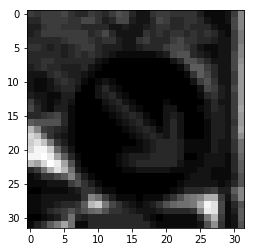

min = 0 - max = 25


In [4]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.

import cv2
from scipy.ndimage import rotate
from sklearn.utils import shuffle

def normalize(img):
    
    # normalize image
    normalizedImg = np.zeros(shape=img.shape)
    normalizedImg = cv2.normalize(img, dst = normalizedImg, alpha=0, beta=25, 
                                  norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    # Add back the 3rd dimension
    if len(normalizedImg.shape) < 3:
        normalizedImg = np.expand_dims(normalizedImg, axis= 2)
    return normalizedImg

def generate_additional_data_rotate(x, y):
    for i in range(43):
        indexes = y == i
        count = np.sum(indexes)
        x_train_sample = x[indexes]
        y_train_sample = y[indexes]
        if count < 750:
            # three random angles between -10 to 10 degress
            three_random_angles = 20.0*np.random.random_sample(3) - 10.0
            x1 = rotate(x_train_sample, three_random_angles[0], axes=(1,2), reshape=False)
            x2 = rotate(x_train_sample, three_random_angles[1], axes=(1,2), reshape=False)
            x3 = rotate(x_train_sample, three_random_angles[2], axes=(1,2), reshape=False)
            X_additional = np.concatenate((x1, x2, x3))
            x = np.concatenate((x, X_additional))
            y = np.concatenate((y, y_train_sample, y_train_sample, y_train_sample))
        elif count < 1500:
            # one random angles between -10 to 10 degress
            one_random_angle = 20.0*np.random.random_sample(1) - 10.0
            x1 = rotate(x_train_sample, one_random_angle[0], axes=(1,2), reshape=False)
            x = np.concatenate((x, x1))
            y = np.concatenate((y, y_train_sample))
            
    return x, y

X_train, y_train = generate_additional_data_rotate(X_train, y_train)
X_train, y_train = generate_additional_data_rotate(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)
    

def ConvertGray(X_gray, X):
    for i in range(X.shape[0]):
        image = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        image = normalize(image)
        X_gray.append(image)
    X_gray = np.reshape(X_gray, (-1, 32, 32, 1))
    return X_gray

X_train_gray, X_valid_gray, X_test_gray = [], [], []
X_train_gray = ConvertGray(X_train_gray, X_train)
X_valid_gray = ConvertGray(X_valid_gray, X_valid)
X_test_gray = ConvertGray(X_test_gray, X_test)

print(X_train_gray.shape)
print(X_train_gray[8955].shape)
plt.imshow(X_train_gray[8955].squeeze(), cmap="gray")
plt.show()
print('min =', np.min(X_train_gray[8955]), '- max =', np.max(X_train_gray[8955]))

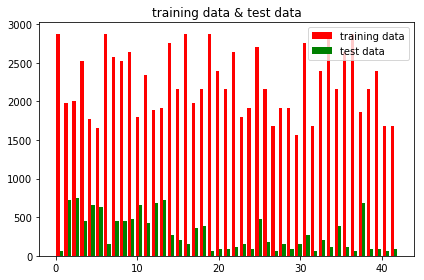

In [5]:
np.random.seed(0)

n_bins = 43
x = y_train, y_test
fig, ax = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'green']
labels = ['training data', 'test data']
ax.hist(x, bins=n_bins, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('training data & test data')

fig.tight_layout()
plt.show()

### Model Architecture

In [6]:
### Define architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 0
    conv0_W = tf.Variable(tf.truncated_normal(shape = (1, 1, 1, 1), mean = mu, stddev = sigma))
    conv0_b = tf.Variable(tf.zeros(1))
    conv0 = tf.nn.conv2d(x, conv0_W, strides = [1, 1, 1, 1], padding = 'SAME') + conv0_b
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(conv0, conv1_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1,2 ,2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    """
    The flatten function flattens a Tensor into two dimensions: (batches, length). 
    In this model, the the output shape of Pooling Layer 2 should be 5x5x16, which equals 400.  
    """
   
    # Dropout
    fc0 = tf.nn.dropout(fc0, 0.75)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape = (400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
### Train model here.
### Calculate and report the accuracy on the training and validation set.

EPOCHS = 20
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, shape = (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32, [])
rate = 0.001

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, keep_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_x = np.reshape(batch_x, (-1, 32, 32, 1))
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        X_valid_gray, y_valid = shuffle(X_valid_gray, y_valid)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train[offset:end]
            batch_x = np.reshape(batch_x, (-1, 32, 32, 1))
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.7})
        
        train_accuracy = evaluate(X_train_gray, y_train, keep_prob)
        validation_accuracy = evaluate(X_valid_gray, y_valid, keep_prob)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    test_accuracy = evaluate(X_test_gray, y_test, keep_prob)
    print("Test accuracy = {:.3f}".format(test_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")
    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Training...

EPOCH 1 ...
Training Accuracy = 0.915
Validation Accuracy = 0.800

EPOCH 2 ...
Training Accuracy = 0.951
Validation Accuracy = 0.849

EPOCH 3 ...
Training Accuracy = 0.966
Validation Accuracy = 0.876

EPOCH 4 ...
Training Accuracy = 0.976
Validation Accuracy = 0.891

EPOCH 5 ...
Training Accuracy = 0.979
Validation Accuracy = 0.904

EPOCH 6 ...
Training Accuracy = 0.981
Validation Accuracy = 0.904

EPOCH 7 ...
Training Accuracy = 0.981
Validation Accuracy = 0.901

EPOCH 8 ...
Training Accuracy = 0.985
Validation Accuracy = 0.919

EPOCH 9 ...
Training Accuracy = 0.985
Validation Accuracy = 0.926

EPOCH 10 ...
Training Accuracy = 0.988
Validation Accuracy = 0.912

EPOCH 11 ...
Training Accuracy = 0.990
Validation Accuracy = 0.923

EPOCH 12 ...
Training Accuracy = 0.990
Validation Accura

---

## Step 3: Test a Model on New Images

use model to predict the traffic sign type of five pictures of German traffic signs from the web.

`signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

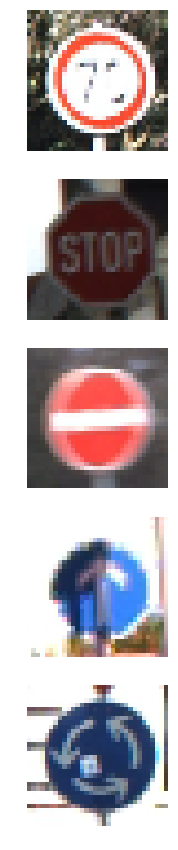

In [11]:
### Load the images and plot them here.
from PIL import Image
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(15, 15)
subdir = 'test_images/'
fname = ['4.jpg','14.jpg','17.jpg','35.jpg','40.jpg']

test_images = np.zeros((5,32,32,3), dtype=np.uint8)
for i in range(5):
    image = mpimg.imread(subdir + fname[i])
    image = cv2.resize(image, (32, 32))
    test_images[i] = image
    plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis('off')

test_images = normalize(test_images)
test_images_gray = []
for i in range(5):
    image = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype(np.float32)
    test_images_gray.append(image)

test_images_gray = np.reshape(test_images_gray, (-1, 32, 32, 1))
test_images_gray = np.asarray(test_images_gray)

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./lenet


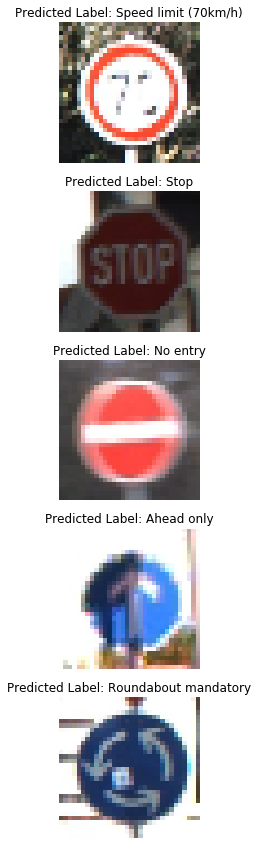

In [12]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
fig = plt.gcf()
fig.set_size_inches(15, 15)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = tf.argmax(logits, 1)
    test_prediction = sess.run(prediction, feed_dict={x: test_images_gray, keep_prob: 1.0})
    
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    class_names = dict(reader)
    
for i in range(5):
    image = mpimg.imread(subdir + fname[i])
    image = cv2.resize(image, (32, 32))
    plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted Label: {}".format(class_names[str(test_prediction[i])]))

### Analyze Performance

In [14]:
### Calculate the accuracy for these 5 new images. 
test_labels = np.array([4, 14, 17, 35, 40])
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(test_images_gray, test_labels, keep_prob)
    print("Image Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from ./lenet
Image Test Accuracy = 100.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet
TopKV2(values=array([[  9.99984145e-01,   1.11542076e-05,   2.93108292e-06],
       [  9.99999166e-01,   7.78456183e-07,   5.92943543e-08],
       [  1.00000000e+00,   5.19671146e-14,   1.29982831e-18],
       [  9.99932170e-01,   3.95914176e-05,   2.75307211e-05],
       [  9.99989033e-01,   1.09524753e-05,   7.46589368e-09]], dtype=float32), indices=array([[ 4, 15,  8],
       [14, 17, 38],
       [17, 14,  9],
       [35, 12, 15],
       [40,  1, 37]], dtype=int32))


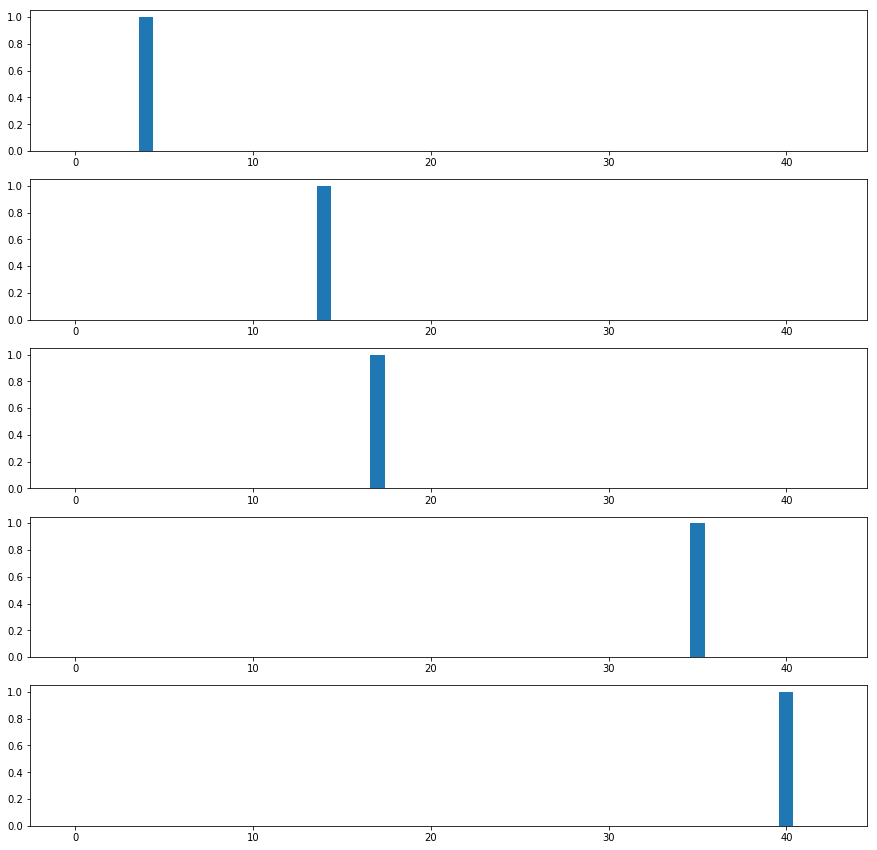

In [15]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)
sess2 = tf.get_default_session()

with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    saver.restore(sess2, tf.train.latest_checkpoint('.'))
    my_softmax_logits = sess2.run(softmax_logits, feed_dict={x: test_images_gray, keep_prob: 1.})
    my_top_k = sess2.run(top_k, feed_dict={x: test_images_gray, keep_prob: 1.})

print(my_top_k)    
fig = plt.figure()
fig.set_size_inches(15, 15)
x_vals = range(43)
for i in range(5):
    ax = fig.add_subplot(5,1, i + 1)
    ax.bar(x_vals, my_softmax_logits[i])
plt.show()